In [1]:
import sys
sys.path.append('..')

from common.download_utils import download_week1_resources

download_week1_resources()

File data/train.tsv is already downloaded.
File data/validation.tsv is already downloaded.
File data/test.tsv is already downloaded.
File data/text_prepare_tests.tsv is already downloaded.


In [2]:
from grader import Grader

In [3]:
grader = Grader()

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [6]:
def read_data(file_path):
    data = pd.read_csv(file_path, sep='\t')
    data['_original_tags'] = data['tags'].copy(deep=True)
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [7]:
train_set, validation_set = read_data('data/train.tsv'), read_data('data/validation.tsv')
test_set = pd.read_csv('data/test.tsv', sep='\t')

In [8]:
train_set.head()

,title,tags,_original_tags
0,How to draw a stacked dotplot in R?,[r],['r']
1,mysql select all records where a datetime fiel...,"[php, mysql]","['php', 'mysql']"
2,How to terminate windows phone 8.1 app,[c#],['c#']
3,get current time in a specific country via jquery,"[javascript, jquery]","['javascript', 'jquery']"
4,Configuring Tomcat to Use SSL,[java],['java']


In [15]:
X_train, y_train = train_set['title'].values, train_set['tags'].values
X_val, y_val = validation_set['title'].values, validation_set['tags'].values
X_test = test_set['title'].values

In [16]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
# remove stopwords
STOPWORDS_RE = re.compile('|'.join(['\\b{0}\\b'.format(x) for x in set(stopwords.words('english'))]))
# compress space
COMPRESS_SPACES_RE = re.compile('( +)') 

def preprocess_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = STOPWORDS_RE.sub('', text)
    text = COMPRESS_SPACES_RE.sub(' ', text)
    # the first word can be a space
    text = text.lstrip()
    return text

def test_preprocess_text():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if preprocess_text(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [17]:
test_preprocess_text()

'Basic tests are passed.'

In [18]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = preprocess_text(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


In [19]:
X_train = [preprocess_text(x) for x in X_train]
X_val = [preprocess_text(x) for x in X_val]
X_test = [preprocess_text(x) for x in X_test]

In [20]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

In [42]:
tags_counts = {}
words_counts = {}

for tag_list in y_train:
    for tag in tag_list:
        tags_counts[tag] = tags_counts[tag] + 1 if tag in tags_counts else 0
            
for sentence in X_train:
    word_list = sentence.split(' ')
    for word in word_list:
        words_counts[word] = words_counts[word] + 1 if word in words_counts else 0


In [60]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)

In [61]:
first_3_most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
first_3_most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in first_3_most_common_tags), 
                                                ','.join(word for word, _ in first_3_most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,,php...


In [62]:
DICT_SIZE = 5000
# take first DICT_SIZE elements
WORDS_TO_INDEX = {word[0]: idx for idx, word in enumerate(most_common_words[:DICT_SIZE])}
INDEX_TO_WORDS = {v: k for k,v in WORDS_TO_INDEX.items()}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    result_vector = np.zeros(dict_size)
    
    word_list = text.split(' ')
    for word in word_list:
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    
    return result_vector

In [63]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [64]:
test_my_bag_of_words()

'Basic tests are passed.'

In [65]:
from scipy import sparse as sp_sparse

In [66]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [67]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = np.count_nonzero(row)

grader.submit_tag('BagOfWords', str(non_zero_elements_count))

Current answer for task BagOfWords is:
 7...


In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [81]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(token_pattern='(\\S+)')
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [82]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [83]:
tfidf_reversed_vocab

{0: '#',
 1: '##',
 2: '#0',
 3: '#0x7f040019',
 4: '#1',
 5: '#10',
 6: '#1045',
 7: '#1052',
 8: '#1064',
 9: '#1075',
 10: '#1136',
 11: '#12',
 12: '#1265',
 13: '#13',
 14: '#19',
 15: '#2',
 16: '#200',
 17: '#2002',
 18: '#2060',
 19: '#2140',
 20: '#26321',
 21: '#3',
 22: '#3115',
 23: '#39',
 24: '#400',
 25: '#411',
 26: '#5',
 27: '#53',
 28: '#53632',
 29: '#6',
 30: '#7',
 31: '#9679',
 32: '#activerecordassociationscollectionproxy',
 33: '#activerecordconnectionadapterstabledefinition0x7f2a8fb07c30',
 34: '#activerecordrelation',
 35: '#anchor',
 36: '#c',
 37: '#class0x007f099c303390',
 38: '#customer',
 39: '#define',
 40: '#defines',
 41: '#deviseregistrationscontroller0x00000003b299b0',
 42: '#div_nameid',
 43: '#egg',
 44: '#endregion',
 45: '#error',
 46: '#fieldshaserrors',
 47: '#g',
 48: '#hash',
 49: '#hellocontroller0x101d7edb0',
 50: '#home',
 51: '#html',
 52: '#htmldocument',
 53: '#htmlinputelement',
 54: '#htmlobjectelement',
 55: '#id',
 56: '#ifdef',
 5

In [84]:
from sklearn.preprocessing import MultiLabelBinarizer

In [85]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [86]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [87]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.

    log_reg = LogisticRegression(random_state=42)
    ovr = OneVsRestClassifier(log_reg)
    ovr_clf = ovr.fit(X_train, y_train)
    return ovr_clf

In [88]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [89]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [90]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	class


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




In [91]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [114]:
def print_evaluation_scores(y_val, predicted):
    print('Accuracy Score: {}'.format(accuracy_score(y_pred=predicted, y_true=y_val)))
    print('F1 Score: {}'.format(f1_score(y_pred=predicted, y_true=y_val, average='weighted')))
    print('AUROC score: {}'.format(roc_auc_score(y_score=predicted, y_true=y_val)))
    print('Average Precision Score: {}'.format(average_precision_score(y_score=predicted, y_true=y_val)))
    print('Recall Score: {}'.format(recall_score(y_pred=predicted, y_true=y_val, average='weighted')))

In [116]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print()
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy Score: 0.3582
F1 Score: 0.648800078137206
AUROC score: 0.7040132741670259
Average Precision Score: 0.344388717440385
Recall Score: 0.5518031105793881

Tfidf
Accuracy Score: 0.3363333333333333
F1 Score: 0.6198790037595722
AUROC score: 0.6768877458249106
Average Precision Score: 0.31162444726933397
Recall Score: 0.5084942744829943


In [119]:
from metrics import roc_auc
%matplotlib inline

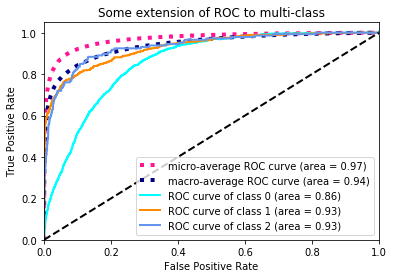

In [120]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

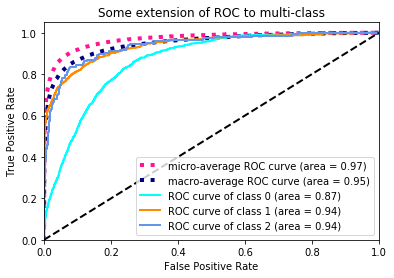

In [121]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

In [122]:
test_predictions = classifier_tfidf.predict(X_test_tfidf)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json
7	java,swing
8	pytho...


In [147]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    
    tag_idx = tags_classes.index(tag)
    coefs = np.squeeze(classifier.estimators_[tag_idx].coef_)
    coefs_with_classes = zip(coefs, tags_classes)
    coefs_with_classes_sorted = sorted(list(coefs_with_classes), key=lambda x: x[0])
    classes_sorted = [x[1] for x in coefs_with_classes_sorted]
    
    top_positive_words = classes_sorted[-5:]
    top_negative_words = classes_sorted[:5]
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [148]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	xcode, visual-studio, osx, ruby, jquery
Top negative words:	.net, validation, angularjs, visual-studio-2010, opencv

Tag:	c++
Top positive words:	jquery, ruby, osx, visual-studio, performance
Top negative words:	.net, datetime, angularjs, linux, xcode

Tag:	linux
Top positive words:	node.js, c#, numpy, ruby-on-rails-3, visual-studio-2010
Top negative words:	validation, jquery, .net, performance, visual-studio



In [149]:
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,,php...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json
7	java,swing
8	pytho...
